# Option Pricer #

This Jupyter Notebook serves to describe how Monte-Carlo methods are used to price options. The option types that I will be analyzing are European options, American options, and Asian options. Other methods for estimating prices of options are using the Black-Scholes formula, binomial methods, and finite difference methods. However, these techniques don't work with more complex instruments seen in exotic options. It is because of this I decided to look into Monte Carlo models.

The underlying model of stock price evolution can be approximated using geometric brownian motion. This is given by the following differential equation:

\begin{equation}
    dS(t)= \mu S(t)dt + \sigma S(t) dB(t)
\end{equation}

Taking the expectation under the risk-neutral measure we can set the drift $\mu$ equal to the risk-free rate. Applying Ito's lemma, modelling the problem with Brownian motion, and rearranging the differential equation, we get the following solution:

\begin{equation}
    ln(S(t)) = ln(S(0)) + (r - \frac{1}{2} \sigma^2)T + \sigma \sqrt{T} N(0,1)
\end{equation}

From this equation, the price of assets can be calculated. From this it is simple to approximate the price of European options as they can only be exercised on their expiration date. Because of this I will begin by analyzing European call-options.

A call option is an option that gives the holder the ability to exercise the option and purchase the underlying asset at the strike price. The opposite of this is a put option, which allow users the ability to exercise the option and sell the underlying asset at the strike price. I will be using call options for the below code. The below codes can easily be modified for put options by changing the order of the strike price and the asset price when the value is being calculated.

### Aside - Martingale Systems: ###

The idea behind a martingale system is that if you have unlimited investing capability, you are guaranteed to increase the value of whatever you are betting. It works when you have 2 equal probability opportunities. Because of this you will be able to bet on one of the outcomes eventually happening. Stopped Brownian motion is an example of a Martingale system.

## European Option Pricer ##

I will begin by calculating the option price for European options as these are the simplest kind. A European option is an option that can be exercised on, but not before, the expiration date. This allows for it to be modelled slightly easier as it isn't path dependent or have other features such as early exercise possibilities (American options) that are seen in exotics.

European Options have 5 main variables we must account for to approximate the price of call and put options. These variables are:

- The option strike price: K
- The risk-free annual rate of return: r
- The volatility of the asset class: sig
- The time to maturity in years: T
- The current price of the underlying asset: S0

In [261]:
import numpy as np
import matplotlib.pyplot as plt

In [262]:
K = 98.01 #Call-Option Strike Price
r = 0.01 #Risk-free rate of return
sig = 0.0991 #Asset volatility
T = 0.5 #Time in years until expiry
S0 = 101.15 #Current Asset Price
numSims = 1000 #Number of simulations
numSteps = 30
dt = T/numSteps

Now, using the law of large numbers and the geometric brownian motion derived above. We can step through time and generate random walks that simulate the price path of the stock. Then, using the law of large numbers and the Monte Carlo model, we are able to approximate the price of the call option by taking the average of all the random walks.

In [263]:
output = np.zeros((numSims, numSteps + 1), dtype=np.float64)
summation = 0

for i in range(numSims):
    output[i][0] = np.log(S0)
    for j in range(numSteps):
        output[i][j+1] = output[i][j] + (r-0.5*(sig**2))*dt + sig * np.sqrt(dt)*np.random.normal()
    finalPrice = np.exp(output[i][-1])
    optionValue = max(0, finalPrice - K)
    summation += optionValue

estimate = np.exp(-r*T) * summation / numSims

print("Call value is ${0}!".format(np.round(estimate,2)))

Call value is $5.13!


Now we can plot all the various different random paths the call option takes to see how they're distributed. From the plot we can see that it takes the form of a normal distribution which is expected.

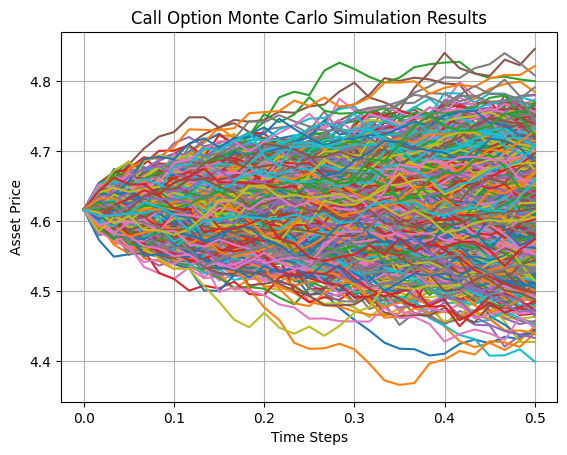

In [264]:
x = np.linspace(0,T,numSteps + 1)

for i in range(numSims):
    plt.plot(x, output[i])

plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.title("Call Option Monte Carlo Simulation Results")
plt.show()

## American Option Pricer ##

American options differ slightly from European options because they have the option to be exercised at anytime prior and on the expiration date. This adds a new component to pricing the option as the optimal exercise time might happen before the expiration date. To deal with this, Longstaff and Schwartz determined that the least-square monte-carlo method would work to help approximate the price of an american option. This is explained in the paper " Valuing American Options by Simulation: A Simple Least-Squares Approach". This approach works by first, simulating random paths of the asset value. Once this is done, analysis is done starting at the expiration date and moving back in time to the present. We regress all the future values of the option to determine an unbiased estimate of the conditional expectation function. This allows us to determine if the optimal time to exercise the option is at that specific time step, or in the future. Doing this all the way to the present allows us to determine n present values of the option where n is the number of simulations for random value paths taken. After this it is easy to take the average of these values and estimate the value of the American option.

The first steps for estimating the price of an American option starts the same as a European option.

In [265]:
K = 40.0 #Call-Option Strike Price
r = 0.06 #Risk-free rate of return
sig = 0.20 #Asset volatility
T = 1.0 #Time in years until expiry
S0 = 36.0 #Current Asset Price
numSims = 10000 #Number of simulations
numSteps = 100
dt = T/numSteps

priceSimulation = np.zeros((numSims, numSteps + 1), dtype=np.float64)

for i in range(numSims):
    priceSimulation[i][0] = S0
    for j in range(numSteps):
        priceSimulation[i][j+1] = priceSimulation[i][j] * np.exp( (r-0.5*(sig**2))*dt + sig * np.sqrt(dt)*np.random.normal())

Once this is done then we need to do the regression to determine the present value of all the paths. The regression is done to estimate the value of continuing to hold the option beyond the current timestep instead of exercising it. Doing so allows us to see if the option is more valuable to hold onto in the future or if to exercise immediately given the random price path. It is important to note that this technique only works assuming the option time steps are discrete and that the option cannot be exercised at anytime, but at specific times.

In [266]:
def optionValue(price):
    for i in range(price.size):
        price[i] = max(K - price[i], 0)
    return price

approximationMatrix = np.zeros((numSims, numSteps + 1), dtype=np.float64)
priceValue = priceSimulation[:,-1]
approximationMatrix[:,-1] = optionValue(priceValue)

for i in range(numSteps - 1, 0, -1):
    coefficients = np.polyfit(priceSimulation[:,i], approximationMatrix[:,i + 1] * np.exp(-r*dt), 5)
    continuedValue = np.polyval(coefficients, priceSimulation[:,i])
    price = optionValue(priceSimulation[:,i])
    approximationMatrix[:, i] = np.where(price > continuedValue, price[i], approximationMatrix[:,i+1]*np.exp(-r*dt))

prices = approximationMatrix[:,1] * np.exp(-r*dt)
value = np.sum(prices) / numSims

print(value)

6.850323662879188


Now lets explain a little bit about what is happening in the regression step as this is the most important step that differs between an American option and a European option. Effectively, we are trying to find the expected future value of the option based on the current value of the option. This is possible by doing a polynomial regression on the price at a current time step and comparing it to the discounted value at the next time step. This equation can be modelled as the following:

\begin{equation}
    E[Y|X] = \alpha_1 + \alpha_2 X + \alpha_3 X^2 + ...
\end{equation}

In the regression we compute the values of alpha that then gives us this nonlinear least squares regression determining the likely future value of the option. Once this is done we can then compare the value of exercising the option at the current time step to exercising it in the future. This allows us to determine the optimal exercise time for each random price path. We effectively create a grid where we compute the approximate increase or decrease between each timestep based on the current value of the asset.

## Asian Option Pricer ##

The final type of option I have decided to build a pricing simulator for using Monte Carlo methods is the Asian option. This option differs from the previous 2 as while it can only be exercised on the expiration date, the value is based on the average price over the period of time. This helps to reduce volatility and makes them cheaper. There are 4 common types of Asian options. These are continuous arithmetic average call or puts, continuous geometric asian call or puts, discrete arithmetic asian call or puts, and discrete geometric average asian call or puts. Because of this feature, Asian options are called path-dependent.

The simplest is when the asian option is sampled at discrete time steps. When this is the case, the value of the asian call option can be modelled with the following equation:

\begin{equation}
    C(T)=(\frac{1}{m} \Sigma_{j=1}^mS(t_j)-K)
\end{equation}

After analyzing this it is clear that the discrete arithmetic average Asian call option can be modelled using the Monte Carlo method in a very similar fashion to European options. There is now a newly added step to calculate the final value of the option, however the rest is the same. The following code snippet shows how the Monte Carlo method can be used to estimate the value of an Asian call option.

In [267]:
K = 95.0 #Call-Option Strike Price
r = 0.15 #Risk-free rate of return
sig = 0.05 #Asset volatility
T = 1.0 #Time in years until expiry
S0 = 100.0 #Current Asset Price
numSims = 10000 #Number of simulations
numSteps = 100
dt = T/numSteps

priceSimulation = np.zeros((numSims, numSteps + 1), dtype=np.float64)
averagedPrices = np.zeros((numSims, 1), dtype=np.float64)
for i in range(numSims):
    priceSimulation[i][0] = S0
    for j in range(numSteps):
        priceSimulation[i][j+1] = priceSimulation[i][j] * np.exp( (r-0.5*(sig**2))*dt + sig * np.sqrt(dt)*np.random.normal())
    averagedPrices[i] = max(np.sum(priceSimulation[i,1:]) / numSteps - K, 0)

average = np.sum(averagedPrices) / numSims
value =np.exp(-r*T) * average
print(value)

11.188137004293926


## Conclusion ##

This Jupyter notebook helped me to gain a strong understanding of the basic types of options and how their prices can be modelled using Monte Carlo methods. I learned about the non-exotic options, American and European, as well as one of the most common basic exotic options the Asian option. I also was able to learn about Monte Carlo methods and how these use probability measures to help estimate values that cannot be found by traditional means. In the future I would like to learn how this method can be applied to other exotic options as well as learn more about antithetic variates and control variates which are variance reduction techniques used to try and "optimize" the previous algorithms to reduce their error.